# Program Prediksi Penyakit Jantung dengan Logistic Regression dan XGBoost

Disusun Oleh:
1. Deva Arya Pradana         (23081010067)
2. Moch. Fikri Nazaruddin    (23081010217)

## 1. Import Semua LIbrary yang dibutuhkan

Library yang digunakan meliputi:
- **Pandas & NumPy** untuk manipulasi data,
- **Matplotlib & Seaborn** untuk visualisasi,
- **Scikit-learn** untuk preprocessing, pipeline, evaluasi, dan baseline model,
- **XGBoost** sebagai model utama,
- **SHAP** untuk explainable AI,
- **Joblib** untuk menyimpan model agar dapat digunakan pada aplikasi Streamlit.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import shap
import joblib

## 2. Load Dataset

Pada tahap ini dilakukan step-step sebagai berikut:
- pembacaan file CSV,
- pengecekan struktur kolom,
- pengecekan tipe data,
- serta identifikasi awal potensi missing value.

In [21]:
df = pd.read_csv("../data/heart.csv")

df.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [23]:
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [24]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

## 3. Target Engineering

Pada tahap selanjutnya, dilakukan proses perubahan target yang berbentuk multiclass menjadi target binary, karena fokus pada sistem adalah memprediksi adanya penyakit jantung, tidak dengan memprediksi tingkat keparahannya.

Dataset asli memiliki kolom num dengan rentang nilai 0–4 yang merepresentasikan tingkat keparahan penyakit jantung.
Namun, dalam konteks prediksi risiko, fokus utama adalah:

0 → Tidak ada penyakit  
1–4 → Ada penyakit

In [25]:
df["target"] = (df["num"] > 0).astype(int)

df.drop(columns=["id", "num"], inplace=True)


## 4. Pengelompokan Fitur

Fitur di dalam dataset kemudian dikelompokkan menjadi dua kelompok, yakni fitur categorical serta fitur numerical. Hal ini dilakukan untuk mempermudah model meng-interpretasikan dan mengolah fitur.

In [26]:
categorical_cols = [
    "sex", "cp", "fbs",
    "restecg", "exang", "slope", "thal"
]

numerical_cols = [
    "age", "trestbps", "chol",
    "thalch", "oldpeak", "ca"
]


## 5. Exploratory Data Analysis (EDA)

Tahapan selanjutnya adalah melakukan EDA untuk mencoba memahami isi dan bentuk dataset 

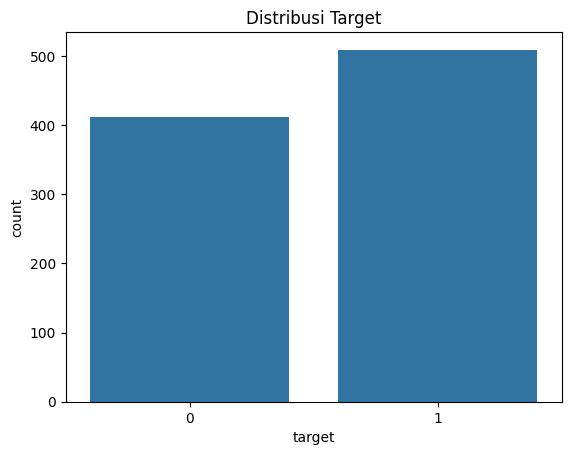

In [27]:
sns.countplot(x="target", data=df)
plt.title("Distribusi Target")
plt.show()


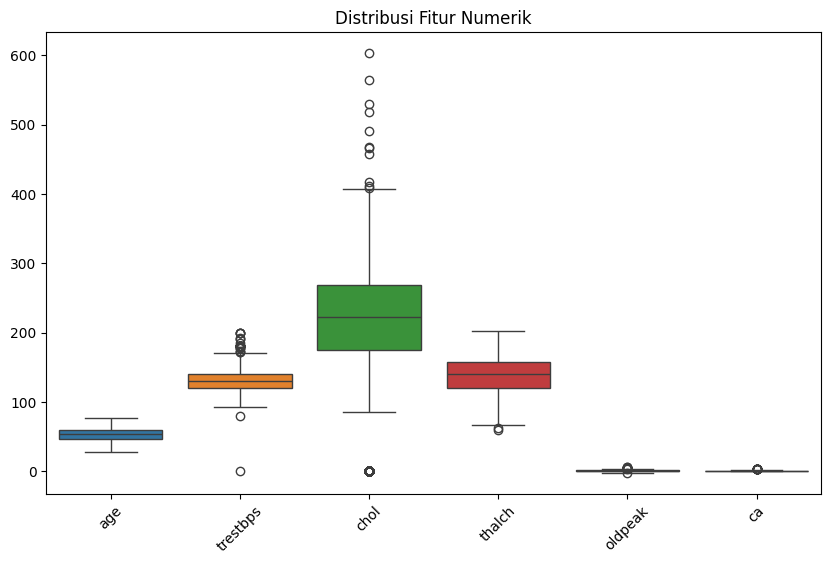

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[numerical_cols])
plt.xticks(rotation=45)
plt.title("Distribusi Fitur Numerik")
plt.show()


## 6. Membuat model dan split dataset untuk training-testing

dataset yang dipakai untuk testing diambil 20 persen dari total keseluruhan dataset, yang berarti jika dataset utuh berjumlah sekitar 920, maka dataset yang digunakan untuk testing berjumlah 184, dan sisanya untuk training

In [29]:
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


## 7. Pipelining untuk Reproducability dan Imputasi untuk Menangani Missing Value

dikarenakan pada dataset terdapat banyak baris yang mempunyai missing value, maka alih-alih dropna(), missing value akan di-imputasi berdasarkan jenis fiturnya. Fitur yang berjenis categorical akan mendapatkan nilai yang paling sering muncul untuk missing value nya, sedangkan fitur yang berjenis numerik akan di scaling, kemudian mendapatkan nilai median untuk missing value nya. 

In [30]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


## 8. Membuat Model Baseline (Logistic Regression)

baseline model yang diplih adalah logistic regression, karena cocok dengan struktur dataset yang diolah dimana dataset hanya berfokus pada fitur numerikal dan kategorikal. Tetapi dapat dilihat bahwa nilai akurasi, presisi, recall, dan yang lainnya masih cukup rendah, maka dari itu diperlukan untuk dilakukan optimasi

In [32]:
lr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)

y_pred_lr = lr_pipeline.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))


Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.79      0.82        82
           1       0.84      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



#### Cek Confusion Matrix Baseline Model

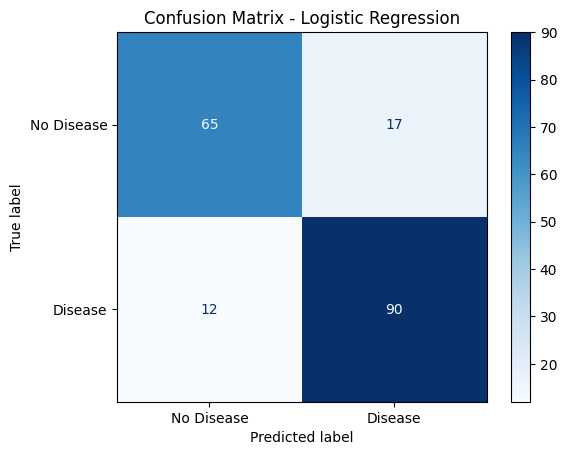

In [33]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=["No Disease", "Disease"]
).plot(cmap="Blues")

plt.title("Confusion Matrix - Logistic Regression")
plt.show()


## 9. Optimasi Model dengan XGBoost serta Tuning Parameter dengan GridSearchCV

Tuning parameter perlu dilakukan untuk menemukan kombinasi parameter terbaik yang perlu digunakan. Beberapa parameter yang akan dicari nilai terbaiknya antara lain:
- n estimator = Jumlah pohon (trees)
- max depth = kedalaman tiap pohon
- learning rate = Seberapa besar kontribusi tiap pohon
- subsample = Proporsi data yang digunakan
- colsample = Proporsi fitur yang digunakan

Gridsearch akan mencoba semua kombinasi yang ada, kemudian menentukan hasil yang terbaik (hasil yang terbaik berdasarkan evaluasi ROC_AUC)

In [34]:
xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        use_label_encoder=False
    ))
])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [2, 3, 4],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:40:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'trestbps',
                                                                          'chol',
                                                                          'thalch',
                                                                          'oldpeak',
                                                                          'ca']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unkno...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [2, 3, 4],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

## 10. Lihat Model, Parameter terbaik yang akhirnya dipilih, serta nilai evaluasi model

Nilai evaluasi model yang ditampilkan meliputi accuracy, precision, recall, f1-score, support, serta ROC-AUC nya

In [35]:
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

y_pred_xgb = best_model.predict(X_test)
y_proba_xgb = best_model.predict_proba(X_test)[:, 1]

print("XGBoost (Tuned)")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))


Best Parameters:
{'model__colsample_bytree': 1.0, 'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 200, 'model__subsample': 0.8}
XGBoost (Tuned)
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        82
           1       0.84      0.92      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.86      0.86       184

ROC-AUC: 0.9197752271640364


#### Tampilkan Confusion Matrix untuk evaluasi

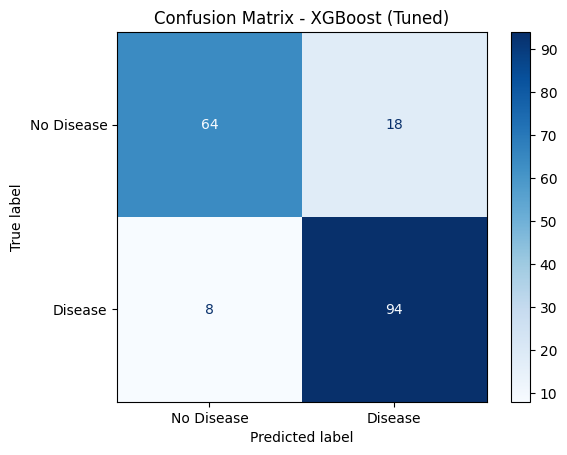

In [36]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

ConfusionMatrixDisplay(
    confusion_matrix=cm_xgb,
    display_labels=["No Disease", "Disease"]
).plot(cmap="Blues")

plt.title("Confusion Matrix - XGBoost (Tuned)")
plt.show()


## 11. Analisis Lanjutan Model dengan SHAP 

Untuk mengetahui bagaimana proses pengambilan keputusan yang dilakukan oleh model, serta untuk mengetahui tingkat kepentingan setiap fitur dalam kalkulasi pada model, kita dapat melakukan analisis menggunakan SHAP (Shapley Additive Explanations). Jenis SHAP yang dipilih untuk digunakan adalah TreeExplainer, karena basis dari model XGBoost sebenarnya adalah decision tree, khususnya boosted tree

SHAP mengukur seberapa berpengaruh nilai di masing-masing fitur untuk hasil akhir pengambilan keputusan oleh model. Semakin besar nilai SHAP dari fitur tersebut, maka semakin fitur tersebut mengarahkan prediksi ke kelas positif. Hal yang sama berlaku sebaliknya, sehingga semakin mendekati nol (0) nilai SHAP dari fitur tersebut, semakin tidak berpengaruh nilai fitur terhadap hasil prediksi model

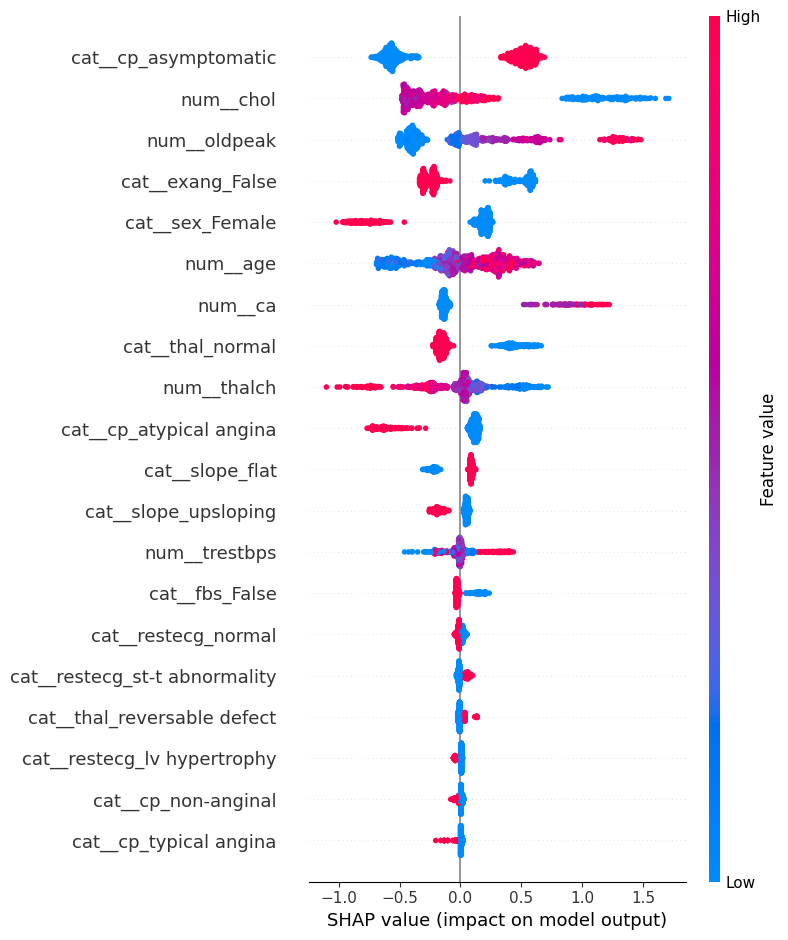

In [37]:
preprocess = best_model.named_steps["preprocess"]
model = best_model.named_steps["model"]

X_train_transformed = preprocess.transform(X_train)
feature_names = preprocess.get_feature_names_out()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

shap.summary_plot(
    shap_values,
    X_train_transformed,
    feature_names=feature_names
)


## 12. Export Model XGBoost untuk Digunakan pada Aplikasi Streamlit kedepannya

In [38]:
joblib.dump(best_model, "../model/xgb_pipeline.pkl")


['../model/xgb_pipeline.pkl']